In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import wget
import matplotlib.pyplot as plt
%matplotlib inline  
from sklearnex import patch_sklearn, config_context
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last" #change to 'all' if needed

## Dataset

In this homework, we will use Credit Card Data from book "Econometric Analysis".

Here's a wget-able [link](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv):

```bash
wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
```






In [4]:
wget.download("https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv")

100% [..............................................................................] 73250 / 73250

'AER_credit_card_data (2).csv'

## Preparation

* The goal of this homework is to inspect the output of different evaluation metrics by creating a classification model (target column `card`). 
* Create the target variable by mapping `yes` to 1 and `no` to 0. 
* Split the dataset into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` funciton for that with `random_state=1`.

In [48]:
df =pd.read_csv("AER_credit_card_data.csv")
df.head()

card  reports       age  income     share  expenditure owner selfemp  \
0  yes        0  37.66667  4.5200  0.033270   124.983300   yes      no   
1  yes        0  33.25000  2.4200  0.005217     9.854167    no      no   
2  yes        0  33.66667  4.5000  0.004156    15.000000   yes      no   
3  yes        0  30.50000  2.5400  0.065214   137.869200    no      no   
4  yes        0  32.16667  9.7867  0.067051   546.503300   yes      no   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5

In [49]:
# for column names:
df.columns = df.columns.str.lower().str.replace(' ', '_')

# for data in the dataframe:
strings = list(df.dtypes[df.dtypes == 'object'].index)
for col in strings:
    df[col] = df[col].str.lower().str.replace(' ', '_')

df.head(10)

card  reports       age  income     share  expenditure owner selfemp  \
0  yes        0  37.66667  4.5200  0.033270   124.983300   yes      no   
1  yes        0  33.25000  2.4200  0.005217     9.854167    no      no   
2  yes        0  33.66667  4.5000  0.004156    15.000000   yes      no   
3  yes        0  30.50000  2.5400  0.065214   137.869200    no      no   
4  yes        0  32.16667  9.7867  0.067051   546.503300   yes      no   
5  yes        0  23.25000  2.5000  0.044438    91.996670    no      no   
6  yes        0  27.91667  3.9600  0.012576    40.833330    no      no   
7  yes        0  29.16667  2.3700  0.076434   150.790000   yes      no   
8  yes        0  37.00000  3.8000  0.245628   777.821700   yes      no   
9  yes        0  28.41667  3.2000  0.019780    52.580000    no      no   

   dependents  months  majorcards  active  
0           3      54           1      12  
1           3      34           1      13  
2           4      58           1       5  
3           0      25           1       7  
4           2      64           1       5  
5           0      54           1       1  
6           2       7           1       5  
7           0      77           1       3  
8           0      97           1       6  
9           0      65           1      18

In [50]:
# checking if any missing values exist in any of the columns:
df.isna().sum(axis=0)

card           0
reports        0
age            0
income         0
share          0
expenditure    0
owner          0
selfemp        0
dependents     0
months         0
majorcards     0
active         0
dtype: int64

C:\Users\Mona\AppData\Local\Temp\ipykernel_3568\4121548936.py:5: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df.hist(bins=100, ax=ax, layout=(3, 3), column=df.columns.values)


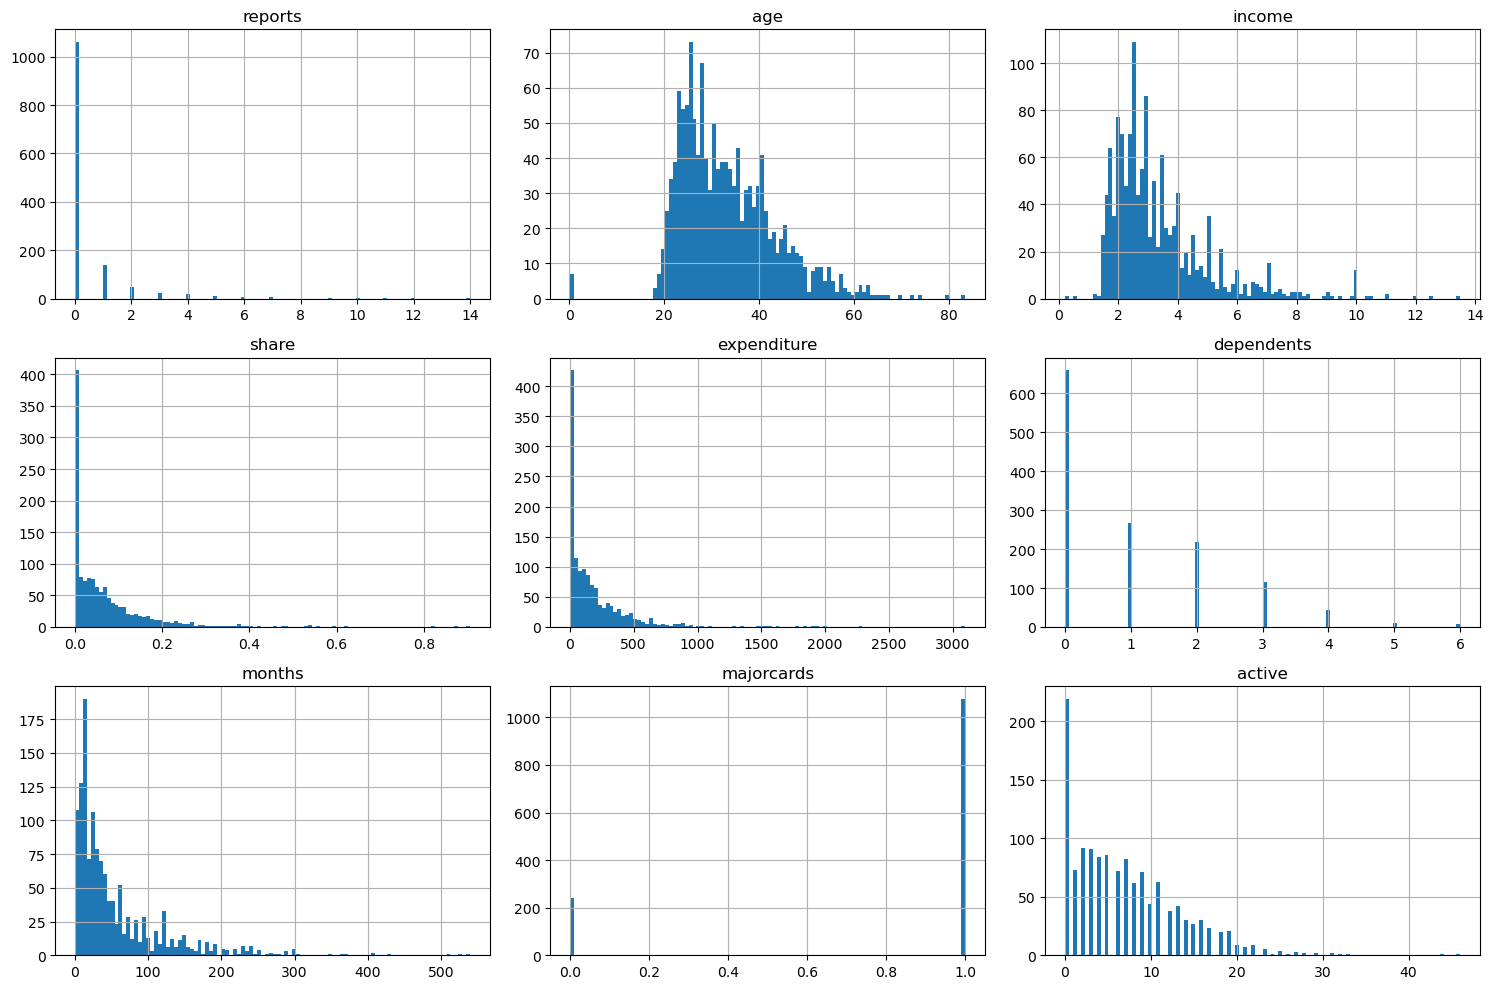

In [51]:
# INSPECTING HISTOGRAM:

fig = plt.figure(figsize=(15,10))
ax = plt.gca()
df.hist(bins=100, ax=ax, layout=(3, 3), column=df.columns.values)
plt.tight_layout()
plt.show()

In [52]:
target = df["card"].copy()
target


0       yes
1       yes
2       yes
3       yes
4       yes
       ... 
1314    yes
1315     no
1316    yes
1317    yes
1318    yes
Name: card, Length: 1319, dtype: object

In [53]:
binary01 = lambda x: 1 if x=="yes" else (0 if x=="no" else float('NaN'))
target = target.apply(binary01)
target

0       1
1       1
2       1
3       1
4       1
       ..
1314    1
1315    0
1316    1
1317    1
1318    1
Name: card, Length: 1319, dtype: int64

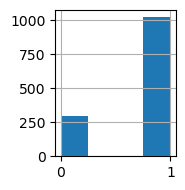

In [54]:
fig = plt.figure(figsize=(2,2))
ax = plt.gca()
target.hist(bins=4, ax=ax)
plt.tight_layout()
plt.show()

We have a class imbalance

In [55]:
# checking if any NaN were added to the target after conversion:
target.isna().sum(axis=0)

0

In [56]:
features = df.drop(columns = "card").copy()
features

reports       age  income     share  expenditure owner selfemp  \
0           0  37.66667  4.5200  0.033270   124.983300   yes      no   
1           0  33.25000  2.4200  0.005217     9.854167    no      no   
2           0  33.66667  4.5000  0.004156    15.000000   yes      no   
3           0  30.50000  2.5400  0.065214   137.869200    no      no   
4           0  32.16667  9.7867  0.067051   546.503300   yes      no   
...       ...       ...     ...       ...          ...   ...     ...   
1314        0  33.58333  4.5660  0.002146     7.333333   yes      no   
1315        5  23.91667  3.1920  0.000376     0.000000    no      no   
1316        0  40.58333  4.6000  0.026513   101.298300   yes      no   
1317        0  32.83333  3.7000  0.008999    26.996670    no     yes   
1318        0  48.25000  3.7000  0.111619   344.157500   yes      no   

      dependents  months  majorcards  active  
0              3      54           1      12  
1              3      34           1      13  
2              4      58           1       5  
3              0      25           1       7  
4              2      64           1       5  
...          ...     ...         ...     ...  
1314           0      94           1      19  
1315           3      12           1       5  
1316           2       1           1       2  
1317           0      60           1       7  
1318           2       2           1       0  

[1319 rows x 11 columns]

## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the `card` variable.
* Use the training dataset for that.

If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['expenditure']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `reports`
- `dependents`
- `active`
- `share`



In [57]:
from sklearn.model_selection import train_test_split

x_train_full, x_test, y_train_full, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size=0.25, random_state=42)

splits = [x_train_full, x_train, x_val, x_test]
for split in splits:
        split.reset_index(inplace = True)
        
splits = [y_train_full,y_train, y_val, y_test]
for split in splits:
         split.reset_index(drop = True, inplace = True)


In [58]:
columns_AUC = ['reports', 'dependents', 'active','share']

for column in columns_AUC:
        AUC = roc_auc_score(y_train, x_train[column])
        if AUC < 0.5:
            AUC = roc_auc_score(y_train, -x_train[column])
        
        print ("AUC is %f for column \"%s\" with target variable \"card" %(AUC, column))


AUC is 0.726507 for column "reports" with target variable "card
AUC is 0.554801 for column "dependents" with target variable "card
AUC is 0.561475 for column "active" with target variable "card
AUC is 0.992087 for column "share" with target variable "card


## Training the model

From now on, use these columns only:

```
["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
```

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```
## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.615
- 0.515
- 0.715
- 0.995

In [59]:
feature_columns = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
x_train = x_train[feature_columns]
x_val = x_val[feature_columns]
x_test = x_test[feature_columns]


In [60]:
from sklearn.feature_extraction import DictVectorizer

def dvectorizer(df_train, df_val):
    

    dv = DictVectorizer(sparse=False)
    
    df_train_dict = df_train.to_dict(orient='records')
    df_train_OH = dv.fit_transform(df_train_dict)
    
    df_val_dict = df_val.to_dict(orient='records')
    df_val_OH = dv.fit_transform(df_val_dict)
    
    
    return df_train_OH , df_val_OH 
    

In [61]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


x_train_OH, x_val_OH = dvectorizer(x_train, x_val)

model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
model.fit(x_train_OH, y_train)
y_pred = model.predict(x_val_OH)

accuracy = round(accuracy_score(y_val, y_pred),3)
accuracy

0.977

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them


At which threshold precision and recall curves intersect?

* 0.1
* 0.3
* 0.6
* 0.8





In [71]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

y_pred_prob = model.predict_proba(x_val_OH)[:, 1]

scores = []
thresholds = np.arange(0,1, 0.01)


for t in thresholds:
    
    precision = precision_score(y_val, y_pred_prob >= t, average = 'binary')
    recall = recall_score(y_val,y_pred_prob >= t, average = 'binary')
    scores.append((t, precision, recall))
    
columns = ['threshold', 'precision','recall']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[::10]

threshold  precision    recall
0         0.0   0.776515  1.000000
10        0.1   0.901786  0.985366
20        0.2   0.961538  0.975610
30        0.3   0.980392  0.975610
40        0.4   0.990099  0.975610
50        0.5   0.995025  0.975610
60        0.6   0.995025  0.975610
70        0.7   0.995025  0.975610
80        0.8   0.995025  0.975610
90        0.9   1.000000  0.975610

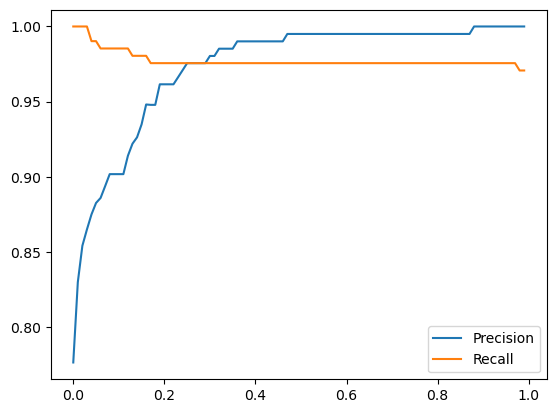

In [72]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.legend()

In [73]:
intersect_idx = df_scores.index[df_scores.precision == df_scores.recall].tolist()
df_scores.threshold[intersect_idx].round(2)

25    0.25
26    0.26
27    0.27
28    0.28
29    0.29
Name: threshold, dtype: float64

After the intersection points, if one increases, the other decreases


## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

F1 = 2 * P * R / (P + R)

Where P is precision and R is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.1
- 0.4
- 0.6
- 0.7


In [74]:
df_scores["f1"] = (2 * df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

max_F1 = df_scores["f1"].max()
max_F1_idx = df_scores["f1"].idxmax()
max_F1_t = df_scores.threshold[max_F1_idx].round(2)


print ("maximum F1 score is %.3f at threshold %.2f" %(max_F1, max_F1_t))

maximum F1 score is 0.988 at threshold 0.88


Just to check with inbuilt F1 score in sklearn:

In [78]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score


y_pred_prob = model.predict_proba(x_val_OH)[:, 1]

scores_f1 = []
thresholds = np.arange(0,1, 0.01)

for t in thresholds:
    f1 = f1_score(y_val, y_pred_prob >= t)
    scores_f1.append((f1))
    
df_scores["f1_sklearn"] = scores_f1

print("Points in the PR curve where P and R intersect:")
df_scores.loc[df_scores.precision == df_scores.recall].round(3)

Points in the PR curve where P and R intersect:


threshold  precision  recall     f1  f1_sklearn
25       0.25      0.976   0.976  0.976       0.976
26       0.26      0.976   0.976  0.976       0.976
27       0.27      0.976   0.976  0.976       0.976
28       0.28      0.976   0.976  0.976       0.976
29       0.29      0.976   0.976  0.976       0.976

In [79]:
print("Point in the PR curve where F1 is maximum:")
df_scores.iloc[df_scores.f1.idxmax(), :].round(3).to_frame().T

Point in the PR curve where F1 is maximum:


threshold  precision  recall     f1  f1_sklearn
88       0.88        1.0   0.976  0.988       0.988

The point of intersection in a plot with both precision and recall is not necessarily the threshold 
of best performing model performance. However, this point can give us a good balance point where neither 
precision nor recall is increasing or decreasing. For overall best performance, choose threshold where F1 is maximized.

PR curves are used for using a threshold for our predicted values when we have a class imbalance. ROC curves are better for choosing threshold for balanced class binary problem.

## Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


How large is standard devidation of the AUC scores across different folds?

- 0.003
- 0.014
- 0.09
- 0.24


In [80]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

In [81]:
n_splits = 5

    
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(x_train_full):

    df_train = x_train_full.iloc[train_idx]
    df_val = x_train_full.iloc[val_idx]

    df_train_OH, df_val_OH = dvectorizer(df_train, df_val)

    y_train = y_train_full.iloc[train_idx]
    y_val = y_train_full.iloc[val_idx]

    y_train.reset_index(drop = True, inplace = True)
    y_val.reset_index(drop = True, inplace = True)


    model = LogisticRegression(solver="liblinear", C=1.0, max_iter=1000, random_state=42)
    model.fit(df_train_OH, y_train)

    y_pred =  model.predict(df_val_OH)
    # y_pred =  model.predict_proba(X)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('With solver= \'liblinear\', mean of AUC-ROC over 5-fold validation is %.3f and std is +- %.3f' % (np.mean(scores), np.std(scores)))

With solver= 'liblinear', mean of AUC-ROC over 5-fold validation is 0.988 and std is +- 0.003


check liblinear, and SAG in previous to see diff. Also, note the parameters and what they do

In [82]:
n_splits = 5

    
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for train_idx, val_idx in kfold.split(x_train_full):

    df_train = x_train_full.iloc[train_idx]
    df_val = x_train_full.iloc[val_idx]

    df_train_OH, df_val_OH = dvectorizer(df_train, df_val)

    y_train = y_train_full.iloc[train_idx]
    y_val = y_train_full.iloc[val_idx]

    y_train.reset_index(drop = True, inplace = True)
    y_val.reset_index(drop = True, inplace = True)


    model = LogisticRegression(solver="sag", C=1.0, max_iter=1000, random_state=42)
    model.fit(df_train_OH, y_train)

    y_pred =  model.predict(df_val_OH)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('With solver= \'sag\', mean of AUC-ROC over 5-fold validation is %.3f and std is +- %.3f' % (np.mean(scores), np.std(scores)))

C:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


With solver= 'sag', mean of AUC-ROC over 5-fold validation is 0.978 and std is +- 0.006


C:\Users\Mona\anaconda3\envs\mlzoomcamp\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


SAG would probably perform better if we ran model for more iterations, but for now, liblinear performs better with lower std over 5 folds.

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10

If you have ties, select the score with the lowest std. If you still have ties, select the smallest C




In [83]:
n_splits = 5

    
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
scores = []

for C in tqdm([0.01, 0.1, 1, 10]):

    for train_idx, val_idx in kfold.split(x_train_full):

        df_train = x_train_full.iloc[train_idx]
        df_val = x_train_full.iloc[val_idx]

        df_train_OH, df_val_OH = dvectorizer(df_train, df_val)

        y_train = y_train_full.iloc[train_idx]
        y_val = y_train_full.iloc[val_idx]

        y_train.reset_index(drop = True, inplace = True)
        y_val.reset_index(drop = True, inplace = True)


        model = LogisticRegression(solver="liblinear", C=C, max_iter=1000, random_state=42)
        model = model.fit(df_train_OH, y_train)

        y_pred =  model.predict(df_val_OH)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('With C=%.2f, mean of AUC-ROC over 5-fold validation is %.4f and std is +- %.4f' % (C, np.mean(scores), np.std(scores)))
    

  0%|          | 0/4 [00:00<?, ?it/s]

With C=0.01, mean of AUC-ROC over 5-fold validation is 0.9873 and std is +- 0.0019
With C=0.10, mean of AUC-ROC over 5-fold validation is 0.9876 and std is +- 0.0027
With C=1.00, mean of AUC-ROC over 5-fold validation is 0.9878 and std is +- 0.0030
With C=10.00, mean of AUC-ROC over 5-fold validation is 0.9874 and std is +- 0.0039


Best results are at C= 1.00 with highest mean AUC-ROC of 0.9878

From the docs: 

C denotes inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

## Submit the results

* Submit your results here: https://forms.gle/8TfKNRd5Jq7sGK5M9
* You can submit your solution multiple times. In this case, only the last submission will be used 
* If your answer doesn't match options exactly, select the closest one